## This notebook compares MC simulation with pilot run data: </br>
MC: 500k muons (muminus) fired in GEANT4 with detector size 23*23$(mm)^2$ area. </br> 
(xmin,xmanx) -> (38.5,61.5), (ymin, ymax) -> (38.5,61.5) BOTH in units of $mm$
</br>
These coordinates are to match pilot run data. There are much more events in pilot data (example, plate 90 as over 3.5million events. 
</br> In future analysis, we should match the density for MC and data

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import math
from matplotlib.ticker import ScalarFormatter
from scipy import stats

#plt.rcParams["figure.figsize"] = (15,10)

In [2]:
muminus_500k = uproot.open("../MC_pilot_data/500k_mu-529-processed.root")
#muminus_500k = uproot.open("../MC_pilot_data/500k_muminus.root")
pilot_90_97 = uproot.open("../MC_pilot_data/plate_90_97.root")
pilot_98_105 = uproot.open("../MC_pilot_data/plate_98_105.root")
pilot_106_113 = uproot.open("../MC_pilot_data/plate_106_113.root")
pilot_114_118 = uproot.open("../MC_pilot_data/plate_114_118.root")
# funtion to get any tree from MC simulation.
def tree_MC(N):
    index='tree'+ str(N)
    return muminus_500k[index]

# funtion to get any tree from pilot data. Note that for this data, 
# there are two tree for each plates. The lower number is 'a back 
# up copy of the meta data' according to this discussion post:
# https://root-forum.cern.ch/t/multiple-trees-with-the-same-name/20878
# update, not specifying takes the most recent/higher by default
# https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html?highlight=cycle
def tree_pilot_data(N):
    index = index='tree'+ str(N)
    if (N >= 90 and N < 98):
        return pilot_90_97[index]
    elif (N >= 98 and N < 106):
        return pilot_98_105[index]
    elif (N >= 106 and N < 114):
        return pilot_106_113[index]
    elif(N >= 114 and N < 119):
        return pilot_114_118[index]
    else:
        print('INVALID PLATE NUMBER')

In [3]:
# this function is used to compare ty and tx of both datasets.
# There are normalized to one and overlaped in a single figure
# one figure is produced for ever plate [90,118] in the specifed folder
def tx_ty_compare(branch,N):
    # extract data
    tree_mc = tree_MC(N)[branch].array()
    tree_pilot = tree_pilot_data(N)[branch].array()
    
    # computing the bin properties (same for both distributions)
    num_bin = 100
    bin_lims = np.linspace(-1,1,num_bin+1)
    bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
    bin_widths = bin_lims[1:]-bin_lims[:-1]
    
    # normalize MC & data to 1
    mc, _ = np.histogram(np.array(tree_mc), bins=bin_lims)
    pilot, _ = np.histogram(np.array(tree_pilot), bins=bin_lims)
    mc_norm = mc/np.max(mc)
    pilot_norm = pilot/np.max(pilot)
    
    # make plots
    fig = plt.figure(figsize=(10,8))
    
    # mc & pilot data imposed in a single plot
    ax = fig.add_gridspec(3,3)
    ax1 = fig.add_subplot(ax[0:2, 0:3])
    ax1.bar(bin_centers, mc_norm, width = bin_widths, align = 'center',label='MC Simulation ')
    ax1.bar(bin_centers, pilot_norm, width = bin_widths,alpha=0.5, align = 'center',label='Pilot Run Data')
    ax1.legend(fontsize=10)
    ax1.set_title(str(branch) +' probability distribution (tree' + str(N) +')',size=15)
    ax1.set_ylabel('probability',size=15)
    
    # ratio of mc/pilot
    ax2 = fig.add_subplot(ax[2, 0:3])
    ax2.plot(bin_centers,mc_norm/pilot_norm,color='gray')
    ax2.set_ylabel('$\dfrac{mc}{pilot}$',size=10)
    ax2.set_xlabel(branch,size=15)
    
    file_name = branch+'/'+branch+'_tree'+str(N)+'.png'
    plt.savefig(file_name,bbox_inches='tight',facecolor='w')
    #plt.show()

In [4]:
#for i in range(90,119):
#    tx_ty_compare('ty',i)

In [5]:
#def tree_pilot_data_float64(N,branch):
#    index = index='tree'+ str(N)
#    if (N >= 90 and N < 98):
#        return np.float64(pilot_90_97[index][branch])
#    elif (N >= 98 and N < 106):
#        return np.float64(pilot_98_105[index][branch])
#    elif (N >= 106 and N < 114):
#        return np.float64(pilot_106_113[index][branch])
#    elif(N >= 114 and N < 119):
#        return np.float64(pilot_114_118[index][branch])
#    else:
#        print('INVALID PLATE NUMBER')

In [26]:
# this function is to be used to compare the the number of bT in x and y
# one figure is produced for every plate [90,118]
# note that the units for MC is in mm. and the units for pilot data is
# in micro-meter. We divide pilot data by 1000 to match units
def x_y(branch,N):
    # extract data
    tree_mc = tree_MC(N)[branch].array()
    tree_pilot = (1/1000)*tree_pilot_data(N)[branch].array()
    
    # get muons
    muon_counter = np.float64(muminus_500k["tree"+str(N)][branch].array())
    pdgid_filter = np.float64(muminus_500k["tree"+str(N)]["pdgid"].array())
    muminus = muon_counter[pdgid_filter==13]
    
    # make plots
    fig = plt.figure(figsize=(10,8))
    
    # mc & pilot data imposed in a single plot
    plt.hist(tree_pilot, bins=100,label='Pilot Run Data')
    plt.hist(tree_mc, bins=100,alpha=0.7,label='MC Simulation ')
    
    plt.hist(muminus,bins=100,alpha=0.5,color='m',label='pdgid=13 (MC)')
    plt.legend(fontsize=10)
    plt.title('Distribution in ' + str(branch) + ' (tree' + str(N) +')',size=15)
    plt.ylabel('count',size=15)
    plt.xlabel('x $(mm)$',size=15)
    plt.xlim(35,63)

    #file_name = branch+'/'+branch+'_tree'+str(N)+'.png'
    #plt.savefig(file_name,bbox_inches='tight',facecolor='w')
    
    plt.show()
    

In [30]:
#for i in range(90,119):
#    x_y('y',i)
    

In [35]:
def get_area(N):
    tree_mc_x = tree_MC(N)['x'].array()
    tree_mc_y = tree_MC(N)['y'].array()
    mc_xmin = np.min(tree_mc_x)
    mc_xmax = np.max(tree_mc_x)
    mc_ymin = np.min(tree_mc_y)
    mc_ymax = np.max(tree_mc_y)
    mc_x_span = mc_xmax - mc_xmin
    mc_y_span = mc_ymax - mc_ymin
    area_mc = (mc_x_span)*(mc_y_span)
    mc = {'area': area_mc,'x_span': mc_x_span,'y_span': mc_y_span,'xmin': mc_xmin, 'xmax': mc_xmax,'ymin': mc_ymin,'ymax': mc_ymax}
    
    tree_pilot_x = tree_pilot_data(N)['x'].array()
    tree_pilot_y = tree_pilot_data(N)['y'].array()
    pilot_xmin = np.min(tree_pilot_x)
    pilot_xmax = np.max(tree_pilot_x)
    pilot_ymin = np.min(tree_pilot_y)
    pilot_ymax = np.max(tree_pilot_y)
    pilot_x_span = pilot_xmax - pilot_xmin
    pilot_y_span = pilot_ymax - pilot_ymin
    area_pilot = (pilot_x_span)*(pilot_y_span)
    pilot = {'area': area_pilot,'x_span': pilot_x_span,'y_span': pilot_y_span ,'xmin': pilot_xmin, 'xmax': pilot_xmax,'ymin': pilot_ymin,'ymax': mc_ymax}
    return[mc, pilot]

In [42]:
def scatter_xy(N):
    data = get_area(N)
    
    tree_mc_x = tree_MC(N)['x'].array()
    tree_mc_y = tree_MC(N)['y'].array()
    
    tree_pilot_x = (1/1000)*tree_pilot_data(N)['x'].array()
    tree_pilot_y = (1/1000)*tree_pilot_data(N)['y'].array()
    
    fig = plt.figure(figsize=(20,10))
    
    # mc simulation
    ax = fig.add_subplot(1,2,1)
    ax.scatter(tree_mc_x,tree_mc_y)
    #ax.hist(tree_mc,bins=100)
    ax.set_xlabel('x',size=15)
    ax.set_ylabel('y',size=15)
    ax.set_title('xy distribution in MC simulation (tree' + str(N)+')' ,size=20)
    #ax.text(-35,0,'area:' + str(data[0]['x_span']) + '$*$' +  str(data[0]['y_span']) + '$=$ ' + str(data[0]['area']) + ' $(u^2)$' ,size=12)
    #ax.text(-30,5,'[xmin,xmax]: [' + str(data[0]['xmin']) + ', ' +  str(data[0]['xmax']) + ']',size=12)
    #ax.text(-30,-5,'[ymin,ymax]: [' + str(data[0]['ymin']) + ', ' +  str(data[0]['ymax']) + ']',size=12)
    
    # pilot run data
    ax = fig.add_subplot(122)
    ax.scatter(tree_pilot_x,tree_pilot_y)
    ax.set_xlabel('x',size=15)
    ax.set_ylabel('y',size=15)
    ax.set_title('xy distribution in pilot run data (tree' + str(N)+')',size=20)
    #ax.text(44000,50000,'area:' + str(data[1]['x_span']) + '$*$' +  str(data[1]['y_span']) + '$=$ ' + str(data[1]['area']) + ' $(u^2)$' ,size=12)
    #ax.text(45000,51250,'[xmin,xmax]: [' + str(data[1]['xmin']) + ', ' +  str(data[1]['xmax']) + ']',size=12)
    #ax.text(45000,48750,'[ymin,ymax]: [' + str(data[1]['ymin']) + ', ' +  str(data[1]['ymax']) + ']',size=12)

    
    #file_name = 'XY/xy_tree'+str(N)+'.png'
    #plt.savefig(file_name,bbox_inches='tight',facecolor='w')
    plt.show()


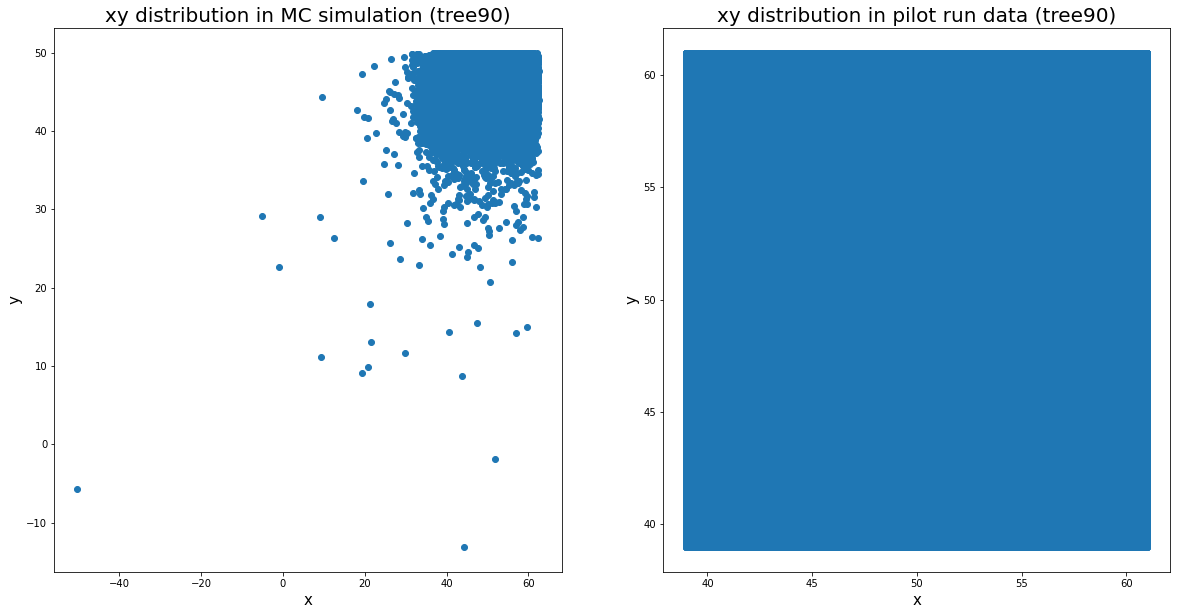

In [43]:
scatter_xy(90)

In [69]:
def scatter_xy(N):
    data = get_area(N)
    
    tree_mc_x = tree_MC(N)['x'].array()
    tree_mc_y = tree_MC(N)['y'].array()
    
    tree_pilot_x = (1/1000)*tree_pilot_data(N)['x'].array()
    tree_pilot_y = (1/1000)*tree_pilot_data(N)['y'].array()
    
    fig = plt.figure(figsize=(20,10))
    
    # mc simulation
    ax = fig.add_subplot(1,2,1)
    ax.scatter(tree_mc_x,tree_mc_y)
    #ax.hist(tree_mc,bins=100)
    ax.set_xlabel('x',size=15)
    ax.set_ylabel('y',size=15)
    ax.set_title('xy distribution in MC simulation (tree' + str(N)+')' ,size=20)
    ax.text(-35,0,'area:' + str(data[0]['x_span']) + '$*$' +  str(data[0]['y_span']) + '$=$ ' + str(data[0]['area']) + ' $(u^2)$' ,size=12)
    #ax.text(-30,5,'[xmin,xmax]: [' + str(data[0]['xmin']) + ', ' +  str(data[0]['xmax']) + ']',size=12)
    #ax.text(-30,-5,'[ymin,ymax]: [' + str(data[0]['ymin']) + ', ' +  str(data[0]['ymax']) + ']',size=12)
    
    # pilot run data
    ax = fig.add_subplot(122)
    ax.scatter(tree_pilot_x,tree_pilot_y)
    ax.set_xlabel('x',size=15)
    ax.set_ylabel('y',size=15)
    ax.set_title('xy distribution in pilot run data (tree' + str(N)+')',size=20)
    ax.text(44,50,'area:' + str(data[1]['x_span']) + '$*$' +  str(data[1]['y_span']) + '$=$ ' + str(data[1]['area']) + ' $(u^2)$' ,size=12)
    ax.text(45,51.25,'[xmin,xmax]: [' + str(data[1]['xmin']) + ', ' +  str(data[1]['xmax']) + ']',size=12)
    ax.text(45,48.75,'[ymin,ymax]: [' + str(data[1]['ymin']) + ', ' +  str(data[1]['ymax']) + ']',size=12)

    
    file_name = 'XY/xy_tree'+str(N)+'.png'
    plt.savefig(file_name,bbox_inches='tight',facecolor='w')
    #plt.show()


In [71]:
#for i in range(91,112):
#    scatter_xy(i)

In [75]:
def muon_count(N):
    
    # get muons
    pdgid_filter = np.float64(muminus_500k["tree"+str(N)]["pdgid"].array())
    muminus = pdgid_filter[pdgid_filter==13]
    return (len(muminus))
    

In [93]:
arr = np.array([])
for i in range(90,119):
    np.append(arr - 90,muon_count(i))
    

In [92]:
len(arr)

0